In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv(r"D:\projects\ETA Prediction\historical_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [4]:
df.head(5)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


Data processing

In [5]:
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'], errors='coerce')

In [6]:
df = df.dropna(subset=['actual_delivery_time'])

In [7]:
df.loc[:, 'market_id'] = df['market_id'].fillna(-1)
df.loc[:, 'order_protocol'] = df['order_protocol'].fillna(-1)
df.loc[:, 'store_primary_category'] = df['store_primary_category'].fillna('unknown')

dashers_columns = ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']
df[dashers_columns] = df[dashers_columns].fillna(df[dashers_columns].median())

df.loc[:, 'estimated_store_to_consumer_driving_duration'] = df['estimated_store_to_consumer_driving_duration'].fillna(
    df['estimated_store_to_consumer_driving_duration'].median()
)

df.loc[:, 'delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()

In [8]:
df = df.drop(columns=['actual_delivery_time'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197421 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     197421 non-null  float64       
 1   created_at                                    197421 non-null  datetime64[ns]
 2   store_id                                      197421 non-null  int64         
 3   store_primary_category                        197421 non-null  object        
 4   order_protocol                                197421 non-null  float64       
 5   total_items                                   197421 non-null  int64         
 6   subtotal                                      197421 non-null  int64         
 7   num_distinct_items                            197421 non-null  int64         
 8   min_item_price                                197421 non-nu

Feature engineering

In [10]:
df['hour'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.dayofweek
df['order_density'] = df['total_outstanding_orders'] / (df['total_onshift_dashers'] + 1e-6)
df['subtotal_items_interaction'] = df['subtotal'] * df['total_items']
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [11]:
df.head(5)

,market_id,created_at,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,...,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration,hour,day_of_week,order_density,subtotal_items_interaction,is_weekend
0,1.0,2015-02-06 22:24:17,1845,american,1.0,4,3441,4,557,1239,...,14.0,21.0,446,861.0,3779.0,22,4,0.636364,13764,0
1,2.0,2015-02-10 21:49:25,5477,mexican,2.0,1,1900,1,1400,1400,...,2.0,2.0,446,690.0,4024.0,21,1,1.999998,1900,0
2,3.0,2015-01-22 20:39:28,5477,unknown,1.0,1,1900,1,1900,1900,...,0.0,0.0,446,690.0,1781.0,20,3,0.000000,1900,0
3,3.0,2015-02-03 21:21:45,5477,unknown,1.0,6,6900,5,600,1800,...,1.0,2.0,446,289.0,3075.0,21,1,1.999998,41400,0
4,3.0,2015-02-15 02:40:36,5477,unknown,1.0,3,3900,3,1100,1600,...,6.0,9.0,446,650.0,2390.0,2,6,1.500000,11700,1


In [12]:
df = df.drop(columns=['created_at'])

In [13]:
numerical_features = ['subtotal', 'min_item_price', 'max_item_price']
df[numerical_features] = df[numerical_features] / 100.0

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
le = LabelEncoder()
df['order_protocol'] = le.fit_transform(df['order_protocol'])

In [16]:
df['store_primary_category'] = le.fit_transform(df['store_primary_category'])

Model training and selection

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X = df.drop(columns=['delivery_duration'])
y = df['delivery_duration']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [21]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2', 0.5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                 param_distributions=param_grid,
                                 n_iter=50,
                                 cv=3, verbose=2, n_jobs=-1)

In [22]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, None],
                                        'max_features': ['sqrt', 'log2', 0.5,
                                                         None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   verbose=2)

In [23]:
best_model = grid_search.best_estimator_

In [24]:
y_pred = best_model.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')

MAE: 713.8217057787009
RMSE: 2633.7218012995545


In [25]:
feature_importance = best_model.feature_importances_
sorted_indices = np.argsort(feature_importance)[::-1]

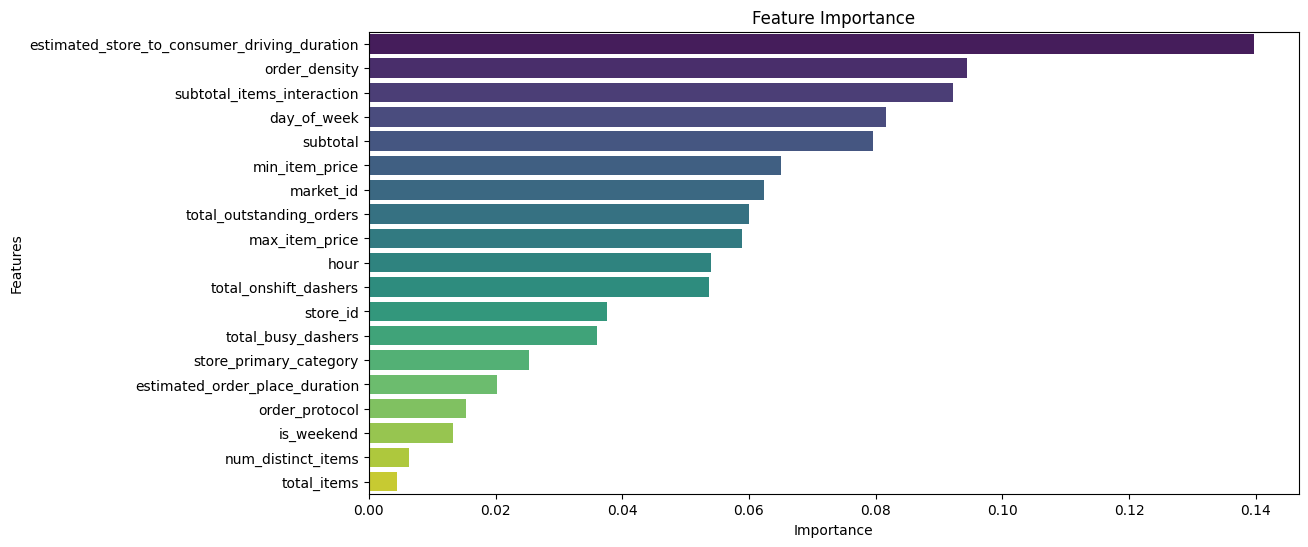

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance[sorted_indices], y=X.columns[sorted_indices], palette="viridis", hue=None)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

Model inference code block

In [27]:
def preprocess_and_predict(input_data, model):
    """
    Preprocess input data and predict ETA using the trained model.
    
    Parameters:
    - input_data (pd.DataFrame): Raw input data for prediction.
    - model: Trained machine learning model.
    
    Returns:
    - Dataframe with predictions.
    """
    # Handle missing categorical features
    input_data['market_id'] = input_data['market_id'].fillna(-1)
    input_data['order_protocol'] = input_data['order_protocol'].fillna(-1)
    input_data['store_primary_category'] = input_data['store_primary_category'].fillna('unknown')

    # Handle missing numerical features
    dashers_columns = ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']
    input_data[dashers_columns] = input_data[dashers_columns].fillna(input_data[dashers_columns].median())
    input_data['estimated_store_to_consumer_driving_duration'] = input_data['estimated_store_to_consumer_driving_duration'].fillna(
        input_data['estimated_store_to_consumer_driving_duration'].median()
    )

    # Feature engineering
    input_data['hour'] = pd.to_datetime(input_data['created_at']).dt.hour
    input_data['day_of_week'] = pd.to_datetime(input_data['created_at']).dt.dayofweek
    input_data['order_density'] = input_data['total_outstanding_orders'] / (input_data['total_onshift_dashers'] + 1e-6)
    input_data['subtotal_items_interaction'] = input_data['subtotal'] * input_data['total_items']
    input_data['is_weekend'] = input_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    # Normalize numerical features
    numerical_features = ['subtotal', 'min_item_price', 'max_item_price']
    input_data[numerical_features] = input_data[numerical_features] / 100.0

    # Encode categorical features with fallback for unseen labels
    def safe_transform(column, encoder, unknown_label=-1):
        return column.map(lambda x: encoder.transform([x])[0] if x in encoder.classes_ else unknown_label)

    input_data['order_protocol'] = safe_transform(input_data['order_protocol'], le)
    input_data['store_primary_category'] = safe_transform(input_data['store_primary_category'], le)
    input_data['created_at'] = pd.to_datetime(input_data['created_at'], errors='coerce')
    order_times = input_data['created_at']
    
    input_data = input_data.drop(columns=['created_at'], errors='ignore')

    input_data = input_data[X.columns]

    predicted_durations = model.predict(input_data)
    
    predicted_times = order_times + pd.to_timedelta(predicted_durations, unit='s')

    results_df = pd.DataFrame({
        'Order Time': order_times,
        'Predicted Delivery Time': predicted_times.dt.strftime('%Y-%m-%d %H:%M:%S'),
        'Predicted Delivery Duration (seconds)': predicted_durations
    })

    return results_df

In [28]:
# Sample raw input data for prediction
new_data = pd.DataFrame({
    'created_at': ['2024-12-03 14:30:00', '2024-12-04 12:21:00'],
    'market_id': [2, 4],
    'store_id':[5477, 1698],
    'order_protocol': [1, 4],
    'store_primary_category': ['american', 'mediterranean'],
    'subtotal': [1285, 14900],
    'num_distinct_items': [2, 4],
    'min_item_price': [496, 556],
    'max_item_price': [789, 6879],
    'total_items': [2, 6],
    'total_onshift_dashers': [22, 9],
    'total_busy_dashers': [6, 5],
    'total_outstanding_orders': [15, 20],
    'estimated_order_place_duration': [251, 446],
    'estimated_store_to_consumer_driving_duration': [704, 1056]
})

predicted_eta = preprocess_and_predict(new_data, best_model)
print(predicted_eta)

           Order Time Predicted Delivery Time  \
0 2024-12-03 14:30:00     2024-12-03 15:08:32   
1 2024-12-04 12:21:00     2024-12-04 13:36:42   

   Predicted Delivery Duration (seconds)  
0                            2312.861125  
1                            4542.936538  
